## Transformer, Self-Attention и моделирование языка

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader

import datetime
import copy
from IPython.display import clear_output
import youtokentome as yttm

import simcube
from simcube.data import tokenize_corpus, build_vocabulary, \
    save_texts_to_file, LanguageModelDataset, load_war_and_piece_chunks, \
    GreedyGenerator, BeamGenerator
from simcube.pipeline import train_eval_loop, init_random_seed
from simcube.base import get_params_number

init_random_seed()

plt.rcParams["figure.figsize"] = (15,10)

## Загрузка текстов и разбиение на обучающую и тестовую подвыборки

In [2]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
all_chunks = load_war_and_piece_chunks('../../data/raw/war_and_peace.txt')
len(all_chunks)

7976

In [3]:
print(all_chunks[10])

у нее был грипп, как она говорила (грипп был тогда новое
слово, употреблявшееся только редкими). В записочках, разосланных утром с
красным лакеем, было написано без различия во всех:
  "Si vous n'avez


In [4]:
np.random.shuffle(all_chunks)

TRAIN_SPLIT = int(len(all_chunks) * 0.7)
train_texts = all_chunks[:TRAIN_SPLIT]
test_texts = all_chunks[TRAIN_SPLIT:]

print('Размер обучающей выборки', len(train_texts))
print('Размер валидационной выборки', len(test_texts))

Размер обучающей выборки 5583
Размер валидационной выборки 2393


In [6]:
train_texts[0]

' от восторга, с толпою\nпобежал за ним.\n\n                  XXI.\n\n    На площади куда поехал государь, стояли лицом к лицу справа батальон\nпреображенцев, слева батальон французской гвардии в медвежьих ш'

## Токенизация корпуса с помощью BPE

BPE - Byte Pair Encoding

YouTokenToMe - быстрая реализация BPE

In [7]:
VOCAB_SIZE = 1000

In [8]:
BPE_MODEL_FILENAME = '../../data/processed/war_and_peace_bpe.yttm'
TRAIN_TEXTS_FILENAME = '../../data/processed/war_and_peace_bpe_train.txt'

In [9]:
save_texts_to_file(train_texts, TRAIN_TEXTS_FILENAME)
yttm.BPE.train(data=TRAIN_TEXTS_FILENAME, vocab_size=VOCAB_SIZE, model=BPE_MODEL_FILENAME);

In [10]:
tokenizer = yttm.BPE(BPE_MODEL_FILENAME)

In [11]:
print(' '.join(tokenizer.vocab()))

<PAD> <UNK> <BOS> <EOS> ▁ о а е и н т с л р в к , д м у п я г ь ы з б . ч й - ж ш e х ю s ц a n r i u o t щ э П l Н ф А В m d c О ? ! К Д Б p М v Р " ) С ( ' ; И Т ё 1 h : Я 2 q f Г ъ b g Ч Э 0 3 Е 5 ] [ j 4 I z Л З 6 8 M A 9 7 У Ж V L x X Ф Ш y C Х J B P D E N S k Ц R Q O T ` w Ю H U F G K Ь W Й * & # Щ Z / ▁с ▁п ▁в ▁н то ▁о ▁и ▁к го ал ра ст но ▁- ▁по ен ▁д ер ел ▁б ро ▁не ко во ка ▁ч ▁м ри ▁на ло ть на ли ла ▁з ▁е ▁у ▁т ре ва ни ся сь ак ▁что ру ет ▁ко ▁бы ми ны ня да ▁то ди хо ▁за ▁го ем ▁г ▁он ол ени ▁от ки ви ну каз е, ▁э та ▁П ти ши ▁при ▁вы ▁ра му ▁Н ▁ж ов ▁вс ле ▁А до ▁В ▁про ▁мо ля ▁как мо ▁во казал ры ▁его ма ▁об сто ▁это ль й, ▁сказал ере не ▁а ▁до ▁О ▁я ▁К ▁кото ▁сво ▁кня ▁Д м, у, ше ▁Б али по чи ▁но сти ▁ни си ча ста ель ▁из ве лу ала де ▁Ан вори ▁М ▁под ▁ка ▁d .. ша ... за ска жи ще es я, лся ▁со че лы зь сть ско ou ▁ли ▁хо ▁ви ▁ст ень ▁ру ря енно ▁Пь ▁так ме ты ▁p ▁Р ги га дел лю сно re же ▁раз ▁( со те ду ку ▁се ски ▁c ▁С ▁ва вши ▁все тель бе en вал ▁l ▁дру ▁было ▁И on

In [12]:
len(tokenizer.vocab())

1000

In [13]:
print(tokenizer.encode(train_texts[:1]))

[[210, 238, 244, 13, 317, 16, 147, 200, 12, 265, 35, 161, 337, 490, 203, 269, 447, 4, 111, 111, 96, 27, 415, 148, 176, 551, 201, 726, 199, 161, 848, 889, 772, 23, 16, 690, 179, 585, 18, 154, 412, 19, 382, 157, 186, 635, 10, 518, 774, 363, 670, 157, 793, 37, 7, 426, 791, 186, 635, 10, 518, 774, 650, 25, 988, 206, 186, 13, 201, 8, 149, 474, 17, 275, 31, 23, 8, 34, 444]]


In [14]:
train_token_ids = tokenizer.encode(train_texts, bos=True, eos=True)
test_token_ids = tokenizer.encode(test_texts, bos=True, eos=True)

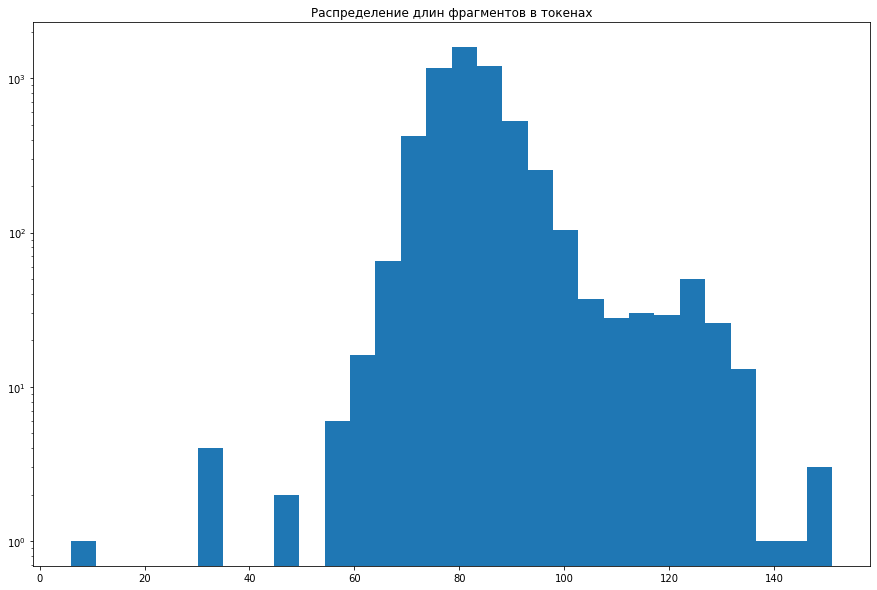

In [15]:
plt.hist([len(sent) for sent in train_token_ids], bins=30)
plt.title('Распределение длин фрагментов в токенах')
plt.yscale('log');

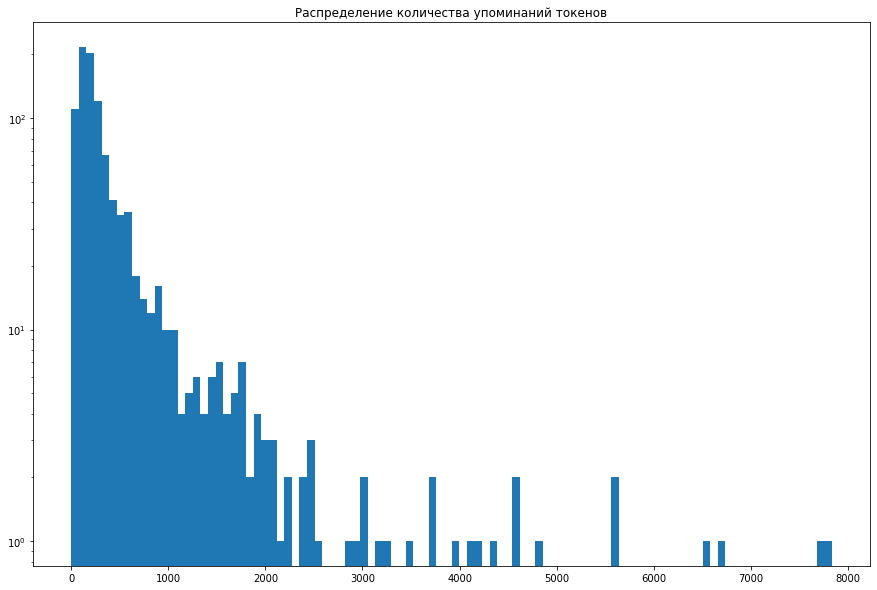

In [16]:
token_counts = np.bincount([token_id for text in train_token_ids for token_id in text])
plt.hist(token_counts, bins=100)
plt.title('Распределение количества упоминаний токенов')
plt.yscale('log');

In [17]:
unknown_subwords_in_test = sum(1 for text in test_token_ids for token_id in text if token_id == 1)
print('Количество случаев с неизвестными n-граммами символов в валидационной выборке', unknown_subwords_in_test)

Количество случаев с неизвестными n-граммами символов в валидационной выборке 0


## Подготовка датасетов для PyTorch

In [16]:
CHUNK_LENGTH = 80

train_dataset = LanguageModelDataset(train_token_ids, chunk_length=CHUNK_LENGTH)
test_dataset = LanguageModelDataset(test_token_ids, chunk_length=CHUNK_LENGTH)

In [17]:
train_dataset[0]

(array([  2, 210, 238, 244,  13, 317,  16, 147, 200,  12, 265,  35, 161,
        337, 490, 203, 269, 447,   4, 111, 111,  96,  27, 415, 148, 176,
        551, 201, 726, 199, 161, 848, 889, 772,  23,  16, 690, 179, 585,
         18, 154, 412,  19, 382, 157, 186, 635,  10, 518, 774, 363, 670,
        157, 793,  37,   7, 426, 791, 186, 635,  10, 518, 774, 650,  25,
        988, 206, 186,  13, 201,   8, 149, 474,  17, 275,  31,  23,   8,
         34, 444]),
 array([210, 238, 244,  13, 317,  16, 147, 200,  12, 265,  35, 161, 337,
        490, 203, 269, 447,   4, 111, 111,  96,  27, 415, 148, 176, 551,
        201, 726, 199, 161, 848, 889, 772,  23,  16, 690, 179, 585,  18,
        154, 412,  19, 382, 157, 186, 635,  10, 518, 774, 363, 670, 157,
        793,  37,   7, 426, 791, 186, 635,  10, 518, 774, 650,  25, 988,
        206, 186,  13, 201,   8, 149, 474,  17, 275,  31,  23,   8,  34,
        444,   3]))

In [18]:
tokenizer.decode(list(train_dataset[0]))

['<BOS> от восторга, с толпою побежал за ним. XXI. На площади куда поехал государь, стояли лицом к лицу справа батальон преображенцев, слева батальон французской гвардии в медвежьих ш',
 'от восторга, с толпою побежал за ним. XXI. На площади куда поехал государь, стояли лицом к лицу справа батальон преображенцев, слева батальон французской гвардии в медвежьих ш<EOS>']

## Общие классы и функции

### Маска зависимостей

In [35]:
def make_target_dependency_mask(length):
    full_mask = torch.ones(length, length)
    ignore_mask = torch.tril(full_mask) < 1
    full_mask.masked_fill_(ignore_mask, float('-inf'))
    full_mask.masked_fill_(~ignore_mask, 0)
    return full_mask

In [36]:
make_target_dependency_mask(10)

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

### Кодирование позиции

In [37]:
def make_positional_encoding(max_length, embedding_size):
    time = np.pi * torch.arange(0, max_length).float()
    freq_dividers = torch.arange(1, embedding_size // 2 + 1).float()
    inputs = time[:, None] / freq_dividers[None, :]
    
    result = torch.zeros(max_length, embedding_size)
    result[:, 0::2] = torch.sin(inputs)
    result[:, 1::2] = torch.cos(inputs)
    return result

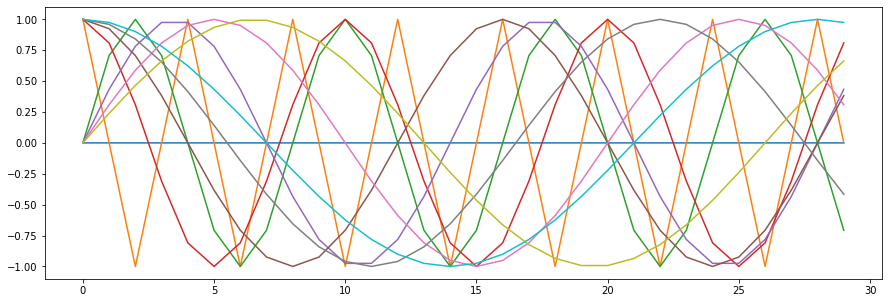

In [38]:
sample_pos_codes = make_positional_encoding(30, 30)
plt.plot(sample_pos_codes[:, ::3].numpy());
plt.gcf().set_size_inches((15, 5))

### Основной класс - языковая модель

In [25]:
class LanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_size, backbone, emb_dropout=0.0):
        super().__init__()
        self.embedding_size = embedding_size
        self.embeddings = nn.Embedding(vocab_size, embedding_size, padding_idx=0)
        self.emb_dropout = nn.Dropout(emb_dropout)
        self.backbone = backbone
        self.out = nn.Linear(embedding_size, vocab_size)
    
    def forward(self, seed_token_ids):
        """
            seed_token_ids - BatchSize x MaxInLen
        """
        batch_size, max_in_length = seed_token_ids.shape

        seed_padding_mask = seed_token_ids == 0
        dependency_mask = make_target_dependency_mask(max_in_length) \
            .to(seed_token_ids.device)
        
        seed_embs = self.embeddings(seed_token_ids)  # BatchSize x MaxInLen x EmbSize
        pos_codes = make_positional_encoding(max_in_length,
                                             self.embedding_size).unsqueeze(0).to(seed_embs.device)
        seed_embs = seed_embs + pos_codes
        seed_embs = self.emb_dropout(seed_embs)

        # BatchSize x TargetLen x EmbSize
        target_features = seed_embs
        target_features = self.backbone(seed_embs,
                                        mask=dependency_mask,
                                        src_key_padding_mask=seed_padding_mask)
        logits = self.out(target_features)  # BatchSize x TargetLen x VocabSize
        return logits

### Утилиты для обучения - функция потерь и расписание изменения длины градиентного шага

In [26]:
def lm_cross_entropy(pred, target):
    """
    pred - BatchSize x TargetLen x VocabSize
    target - BatchSize x TargetLen
    """
    pred_flat = pred.view(-1, pred.shape[-1])  # BatchSize*TargetLen x VocabSize
    target_flat = target.view(-1)  # BatchSize*TargetLen
    return F.cross_entropy(pred_flat, target_flat, ignore_index=0)


def lr_scheduler(optimizer):
    return torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                      patience=20,
                                                      factor=0.5,
                                                      verbose=True)

## Реализация Transformer из PyTorch 1.2

In [27]:
def copy_data_to_device(data, device):
    if torch.is_tensor(data):
        return data.to(device)
    elif isinstance(data, (list, tuple)):
        return [copy_data_to_device(elem, device) for elem in data]
    raise ValueError('Недопустимый тип данных {}'.format(type(data)))


In [28]:
def train_eval_loop(model, train_dataset, val_dataset,
                    criterion,
                    lr=1e-4,
                    epoch_n=10,
                    batch_size=32,
                    device=None,
                    early_stopping_patience=10,
                    l2_reg_alpha=0,
                    max_batches_per_epoch_train=10000,
                    max_batches_per_epoch_val=1000,
                    data_loader_ctor=DataLoader,
                    optimizer_ctor=None,
                    lr_scheduler_ctor=None,
                    shuffle_train=True,
                    dataloader_workers_n=0):
    """
    Цикл для обучения модели. После каждой эпохи качество модели оценивается по отложенной выборке.
    :param model: torch.nn.Module - обучаемая модель
    :param train_dataset: torch.utils.data.Dataset - данные для обучения
    :param val_dataset: torch.utils.data.Dataset - данные для оценки качества
    :param criterion: функция потерь для настройки модели
    :param lr: скорость обучения
    :param epoch_n: максимальное количество эпох
    :param batch_size: количество примеров, обрабатываемых моделью за одну итерацию
    :param device: cuda/cpu - устройство, на котором выполнять вычисления
    :param early_stopping_patience: наибольшее количество эпох, в течение которых допускается
        отсутствие улучшения модели, чтобы обучение продолжалось.
    :param l2_reg_alpha: коэффициент L2-регуляризации
    :param max_batches_per_epoch_train: максимальное количество итераций на одну эпоху обучения
    :param max_batches_per_epoch_val: максимальное количество итераций на одну эпоху валидации
    :param data_loader_ctor: функция для создания объекта, преобразующего датасет в батчи
        (по умолчанию torch.utils.data.DataLoader)
    :return: кортеж из двух элементов:
        - среднее значение функции потерь на валидации на лучшей эпохе
        - лучшая модель
    """
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Выбранное устройство: {device}")
    device = torch.device(device)
    model.to(device)

    if optimizer_ctor is None:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2_reg_alpha)
    else:
        optimizer = optimizer_ctor(model.parameters(), lr=lr)

    if lr_scheduler_ctor is not None:
        lr_scheduler = lr_scheduler_ctor(optimizer)
    else:
        lr_scheduler = None

    train_dataloader = data_loader_ctor(train_dataset, batch_size=batch_size, shuffle=shuffle_train,
                                        num_workers=dataloader_workers_n)
    val_dataloader = data_loader_ctor(val_dataset, batch_size=batch_size, shuffle=False,
                                      num_workers=dataloader_workers_n)

    best_val_loss = float('inf')
    best_epoch_i = 0
    best_model = copy.deepcopy(model)

    history_mean_train_loss = []
    history_mean_val_loss = []  
    
    for epoch_i in range(epoch_n):
        try:
            epoch_start = datetime.datetime.now()
#             print('Эпоха {}'.format(epoch_i))

            model.train()
            mean_train_loss = 0
            train_batches_n = 0
            for batch_i, (batch_x, batch_y) in enumerate(train_dataloader):
                if batch_i > max_batches_per_epoch_train:
                    break

                batch_x = copy_data_to_device(batch_x, device)
                batch_y = copy_data_to_device(batch_y, device)

                pred = model(batch_x)
                loss = criterion(pred, batch_y)

                model.zero_grad()
                loss.backward()

                optimizer.step()

                mean_train_loss += float(loss)
                train_batches_n += 1

            mean_train_loss /= train_batches_n
#             print('Эпоха: {} итераций, {:0.2f} сек'.format(train_batches_n, (datetime.datetime.now() - epoch_start).total_seconds()))
#             print('Среднее значение функции потерь на обучении', mean_train_loss)

            model.eval()
            mean_val_loss = 0
            val_batches_n = 0

            with torch.no_grad():
                for batch_i, (batch_x, batch_y) in enumerate(val_dataloader):
                    if batch_i > max_batches_per_epoch_val:
                        break

                    batch_x = copy_data_to_device(batch_x, device)
                    batch_y = copy_data_to_device(batch_y, device)

                    pred = model(batch_x)
                    loss = criterion(pred, batch_y)

                    mean_val_loss += float(loss)
                    val_batches_n += 1

            mean_val_loss /= val_batches_n
#             print('Среднее значение функции потерь на валидации', mean_val_loss)

            if mean_val_loss < best_val_loss:
                best_epoch_i = epoch_i
                best_val_loss = mean_val_loss
                best_model = copy.deepcopy(model)
#                 print('Новая лучшая модель!')
            elif epoch_i - best_epoch_i > early_stopping_patience:
#                 print('Модель не улучшилась за последние {} эпох, прекращаем обучение'.format( early_stopping_patience))
                break

            if lr_scheduler is not None:
                lr_scheduler.step(mean_val_loss)

            history_mean_train_loss.append(mean_train_loss)
            history_mean_val_loss.append(mean_val_loss)
    
            # visualizing training process
            if (epoch_i + 1) % 10 == 0:
                clear_output(True)
                plt.plot(history_mean_train_loss, label='train_loss')
                plt.plot(history_mean_val_loss, label='valid_loss')
                plt.legend()
                plt.show()
        
            print()
        except KeyboardInterrupt:
            print('Досрочно остановлено пользователем')
            break
        except Exception as ex:
            print('Ошибка при обучении: {}\n{}'.format(ex, traceback.format_exc()))
            break

    return best_val_loss, best_model

In [29]:
class BatchFirstTransformerEncoder(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()
        self.impl = nn.TransformerEncoder(*args, **kwargs)
        self.initialize_weights()
    
    def forward(self, src, *args, **kwargs):
        src = src.transpose(0, 1).contiguous()  # MaxInLen  x BatchSize x EmbSize
        result = self.impl(src, *args, **kwargs)  # TargetLen x BatchSize x EmbSize
        result = result.transpose(0, 1).contiguous()  # BatchSize x TargetLen x EmbSize
        return result
    
    def initialize_weights(self):
        for param in self.impl.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)

In [30]:
torch_transf_model = LanguageModel(
    tokenizer.vocab_size(),
    256,
    BatchFirstTransformerEncoder(
       nn.TransformerEncoderLayer(
           d_model=256,
           nhead=16,
           dim_feedforward=512,
           dropout=0.1),
       num_layers=3),
    emb_dropout=0.1
)

In [31]:
print('Количество параметров', get_params_number(torch_transf_model))

Количество параметров 2094312


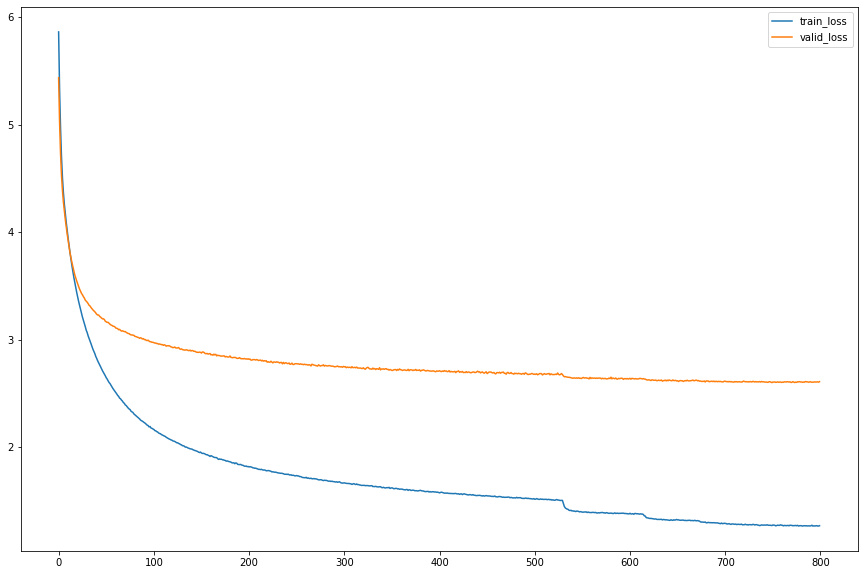


CPU times: user 1h 2min 8s, sys: 4.27 s, total: 1h 2min 13s
Wall time: 53min 10s


In [94]:
%%time

best_val_loss, best_torch_transf_model = train_eval_loop(torch_transf_model, train_dataset, test_dataset,
    lm_cross_entropy,
    lr=2e-3,
    epoch_n=2000,
    batch_size=512,
    device='cuda',
    early_stopping_patience=50,
    max_batches_per_epoch_train=1000,
    max_batches_per_epoch_val=1000,
    lr_scheduler_ctor=lr_scheduler
)

In [96]:
torch.save(best_torch_transf_model.state_dict(), '../../data/models/war_and_peace_torch_transf_best.pth')

In [32]:
torch_transf_model.load_state_dict(torch.load('../../data/models/war_and_peace_torch_transf_best.pth'))

<All keys matched successfully>

In [120]:
!ls -lah ../../data/models

total 230M
drwxrwxr-x 2 science science 4,0K Apr  4 19:25 .
drwxrwxr-x 8 science science 4,0K Apr  2 17:58 ..
-rw-rw-r-- 1 science science 339K Apr  3 15:22 sentence_level_pos.pth
-rw-rw-r-- 1 science science 1,8M Apr  2 17:58 sgns.pth
-rw-rw-r-- 1 science science 189K Apr  3 12:34 single_token_pos.pth
-rw-rw-r-- 1 science science 8,0M Apr  4 19:25 war_and_peace_torch_transf_best.pth
-rw-rw-r-- 1 science science  88M Apr  2 20:21 word2vec_publicru_init_weight.pth
-rw-rw-r-- 1 science science 132M Apr  3 11:33 word2vec_publicru.pth


## Генерация текста с помощью языковой модели

### Жадная генерация

In [33]:
greedy_generator = GreedyGenerator(torch_transf_model, tokenizer)

In [124]:
%%time

print(greedy_generator('сказала княжна, оглядывая Бона'))

сказала княжна, оглядывая Бонапарте. Жюли, вы, как будто не знаете, что вы, не знаете, что вы научения? Такая ваш не понимаете в жен
CPU times: user 1.36 s, sys: 8.24 ms, total: 1.36 s
Wall time: 223 ms


In [125]:
print(greedy_generator('смеялась княжна, оглядывая Наполе'))

смеялась княжна, оглядывая Наполеона. В то время, как из которой он приехал, еще в чем дело, он не мог разобрать, где и когда ему увидал возвращающегося


In [126]:
print(greedy_generator('сказала княжна, оглядывая Кутуз'))

сказала княжна, оглядывая Кутузвался на куртфель и задумался. - Да. - Cont vous avez protifeee au rev


In [131]:
print(greedy_generator('Кутузов'))

Кутузову своего адъютанта. Видно было, что Кутузов и хотел сказать, что Кутузовумяря, не ушел отставал, и


In [130]:
print(greedy_generator('сказал Кутузов, оглядывая Наполеона'))

сказал Кутузов, оглядывая Наполеона и проводил его к маленькой княгине и, заставив закрыв глаза и нагнувшись, поехал к нему. Ростов принял его и, ув


In [39]:
# Надо жить, надо любить, надо верить.
print(greedy_generator('Надо жить'))

Надо жить вра. "Шенгерский дорог", думал он, загал обращаясь к француженскому. - Il est sui m'a


In [40]:
# Последнее время мне стало жить тяжело. Я вижу, я стал понимать слишком много.
print(greedy_generator('Последнее время мне стало жить тяжело'))

Последнее время мне стало жить тяжело для офице посие мардше. Его было несчастство. И скорее, ли я разобравляю его поручения Бонапарта


In [41]:
# Кто всё поймет, тот всё и простит.
print(greedy_generator('Кто всё поймет'))

Кто всё поймет! Претри учтоже и вместе с темная армию mon ридине. Имприонием роту и близалит про


In [42]:
# Сражение выигрывает тот, кто твердо решил его выиграть!
print(greedy_generator('Сражение выигрывает тот'))

Сражение выигрывает тот же почтительной жестокий удар перед ряды и с высоко главнокомандующего шел в сени. Справа книл По-


In [43]:
# Несмотря на то, что доктора лечили его, пускали кровь и давали пить лекарства, он всё-таки выздоровел.
print(greedy_generator('Несмотря на то'))

Несмотря на товарищая, как бы вы были волны люди, женившие ту то самое блестящие, глазах, благородным, она привычно тут други


In [44]:
# Несмотря на то, что доктора лечили его, пускали кровь и давали пить лекарства, он всё-таки выздоровел.
print(greedy_generator('давали пить лекарства'))

давали пить лекарства и испуганно оглядывалась, что он с неизменем и не спрашивал его во весь роде должен ей догадать полк,


In [45]:
# Мы не столько любим людей за то добро, которое они сделали нам, сколько за то добро, которое сделали им мы.
print(greedy_generator('Мы не столько любим людей за то добро'))

Мы не столько любим людей за то добром. Види, который слушая людими предполитали назад сидел на кресла, придле по никогда не понимая, они задум


In [46]:
# Ничем не может владеть человек, пока боится смерти. А кто не боится её, тому принадлежит всё.
print(greedy_generator('Ничем не может владеть человек'))

Ничем не может владеть человек. В этаку с Петрд`ор Вюсь теперь воображжавшему ему Анна Павловна, но порыдавая ему необходимость


### Генерация с помощью лучевого поиска - Beam Search

In [48]:
beam_generator = BeamGenerator(torch_transf_model, tokenizer)

In [103]:
%%time

beam_gen_variants = beam_generator('сказала княжна, оглядывая Наполе',
                                   beamsize=5,
                                   return_hypotheses_n=5)

for score, pred_txt in beam_gen_variants:
    print('****')
    print(score)
    print(pred_txt)
    print()

****
2.5131449607796212
сказала княжна, оглядывая Наполеона. - C'est la campagne. Non, je vous citerains, que je vous crois que je

****
2.5222256173024693
сказала княжна, оглядывая Наполеона. - C'est la prince Hipole, 49 - говорил Лаврушка. - Voyons, 19

****
2.5800589159144995
сказала княжна, оглядывая Наполеона. - C'est la prince Hipole, 49 - отвечал он. Княгиня, улыбаясь и отчаянно взмахнул

****
2.6016618394571585
сказала княжна, оглядывая Наполеона. - C'est la prince Hipole, 49 - отвечал он. Княгиня, улыбаясь и отчаянно взмахну

****
2.619141115341512
сказала княжна, оглядывая Наполеона. - C'est la prince Hipole, 49 - отвечал он. Княгиня, улыбаясь и раскрываясь от нее. Она

CPU times: user 5.38 s, sys: 44.1 ms, total: 5.42 s
Wall time: 853 ms


In [104]:
%%time

beam_gen_variants = beam_generator('сказала княжна, оглядывая Наполе',
                                   beamsize=20,
                                   return_hypotheses_n=20)

for score, pred_txt in beam_gen_variants:
    print('****')
    print(score)
    print(pred_txt)
    print()

****
1.499354916812134
сказала княжна, оглядывая Наполеона. XVIII. Пройдя коридор, флигель-адъютант учтивостью передал Болкон

****
1.532520912537454
сказала княжна, оглядывая Наполеон, приставши прежде к плоту, быстрыми шагами пошел вперед и, встречая Александра, подал ему ру

****
1.7461463614648138
сказала княжна, оглядывая Наполеона. XVIII. Пройдя коридор, состоял из себя в Лысых Горах. Маленький Николушка

****
1.926889580968508
сказала княжна, оглядывая Наполеон, приставши прежде к плоту, быстрыми шагами пошел вперед и, встречаящими глазами глядя на Ростова. -

****
1.98223439477454
сказала княжна, оглядывая Наполеон, приставши прежде к плоту, быстрыми шагами пошел вперед и, встречаящими, толстыми пальцами, т

****
2.010063183344271
сказала княжна, оглядывая Наполеон, приставши прежде к плоту, быстрыми шагами пошел вперед и, встречая пошел вперед и, обращаясь к князю

****
2.158409435379314
сказала княжна, оглядывая Наполеон, приставши прежде к плоту, быстрыми шагами пошел вперед

In [105]:
%%time

beam_gen_variants = beam_generator('сказала княжна, оглядывая Наполе',
                                   beamsize=100,
                                   return_hypotheses_n=20)

for score, pred_txt in beam_gen_variants:
    print('****')
    print(score)
    print(pred_txt)
    print()

****
1.0487984976048306
сказала княжна, оглядывая Наполеона. В этот самый день Ростов, пользуясь темнотой, чтобы не быть узнанным, в статском платье, приехал в Ти

****
1.413859259105773
сказала княжна, оглядывая Наполеона. В этот самый день Ростов, пользуясь темнотой, чтобы не быть узнанным, в статском платье в клубе,

****
1.4474844868924677
сказала княжна, оглядывая Наполеона. В этот самый день Ростов, пользуясь темнотой, чтобы не быть узнанным, в статском платья графиня и за

****
1.4864090233885703
сказала княжна, оглядывая Наполеона. В этот самый день Ростов, пользуясь темнотой, чтобы не быть узнанным, в статском платьях вечер,

****
1.499354916812134
сказала княжна, оглядывая Наполеона. XVIII. Пройдя коридор, флигель-адъютант учтивостью передал Болкон

****
1.5033953497327401
сказала княжна, оглядывая Наполеона. В этот самый день Ростов, пользуясь темнотой, чтобы не быть узнанным, в статском платьях французов. На

****
1.5236502484726269
сказала княжна, оглядывая Наполеона. В эт

In [49]:
# Надо жить, надо любить, надо верить.
beam_gen_variants = beam_generator('Надо жить',
                                   beamsize=5,
                                   return_hypotheses_n=5)

for score, pred_txt in beam_gen_variants:
    print('****')
    print(score)
    print(pred_txt)
    print()

****
3.9369850661779773
Надо жить для других, он очень хорош, сколько раз усх просить только трудца. - Нет. - Здорова Бого Бога, - сказал он

****
3.947147864303324
Надо жить для других, он очень хорош, сколько раз усх просить только трудца. - Нет. - Здорова Бого Богу, - сказал Пьер

****
3.9574465267916867
Надо жить для других, он очень хорош, сколько раз усх просить только трудца. - Нет. - Здорова Бого Богу, - сказал он.

****
4.016480814582185
Надо жить для других, он очень хорош, сколько раз усх просить только трудца. - Нет. - Здорова Бого Бога, - сказал он,

****
4.019147925479852
Надо жить для других, он очень хорош, сколько раз усх просить только трудца. - Нет. - Здорова Бога, - сказал фельд



In [50]:
# Последнее время мне стало жить тяжело. Я вижу, я стал понимать слишком много.
beam_gen_variants = beam_generator('Последнее время мне стало жить тяжело',
                                   beamsize=5,
                                   return_hypotheses_n=5)

for score, pred_txt in beam_gen_variants:
    print('****')
    print(score)
    print(pred_txt)
    print()

****
3.0512463603234106
Последнее время мне стало жить тяжело. Я дышу, ты хочу стало быть назначен? В случаешься свитским... Княжна Марья его. - Неужели

****
3.0802601361018156
Последнее время мне стало жить тяжело. Я дышу, ты хочу стало быть назначен? В случаешься свитским, мысли, дам весьма вашей

****
3.087793502206499
Последнее время мне стало жить тяжело. Я дышу, ты хочу стало быть назначен? В случаешься свитским... Княжна Марьна Марья должно было

****
3.0987682605310134
Последнее время мне стало жить тяжело. Я дышу, ты хочу стало быть назначен? В случаешься свитским, мысли, дам весьма ваше в

****
3.1691239841797287
Последнее время мне стало жить тяжело. Я дышу, ты хочу стало быть назначен? В случаешься свитским... Княжна Марья беспокойно и



In [51]:
# Кто всё поймет, тот всё и простит.
beam_gen_variants = beam_generator('Кто всё поймет',
                                   beamsize=5,
                                   return_hypotheses_n=5)

for score, pred_txt in beam_gen_variants:
    print('****')
    print(score)
    print(pred_txt)
    print()

****
2.563996190134474
Кто всё поймет! - закричал Денисов, ударясь, хотя по стол и не отвечал. - Сказавлогра! - кричал один адъютант. -

****
3.026596468532409
Кто всё поймет! - закричал Денисов, ударясь, хотя по стол и не отвечал. - Сказавлогра! - кричал один адъютанту, -

****
3.0348943817097473
Кто всё поймет! - закричал Денисов, ударясь, хотя по стол и не отвечал. - Сказавлогра! - кричал один адъютант. По

****
3.1256275155688984
Кто всё поймет! - закричал Денисов, ударясь, хотя по стол и не отвечал. - Сказавлогра! - кричал один адъютант. Ко

****
3.2664371942844816
Кто всё поймет! - закричал Денисов, ударясь, хотя по стол и не отвечал. - Сказавлогра! - кричал один адъютанту, по



In [52]:
# Сражение выигрывает тот, кто твердо решил его выиграть!
beam_gen_variants = beam_generator('Сражение выигрывает тот',
                                   beamsize=5,
                                   return_hypotheses_n=5)

for score, pred_txt in beam_gen_variants:
    print('****')
    print(score)
    print(pred_txt)
    print()

****
2.9913233840245175
Сражение выигрывает тот несмотря на то, что последнелй ноти в середине России. С вечера между эскадроном и неприятельскими пере

****
3.082797979601616
Сражение выигрывает тот несмотря на то, что последнелй ноти в середине России. С вечера между эскадроном и неприятельскими от

****
3.097740829768173
Сражение выигрывает тот несмотря на то, что последнелй ноти в середине России. С вечера между эскадроном и непринявший приема

****
3.2278968112304596
Сражение выигрывает тот несмотря на то, что последнелй ноти в середине России. С вечера между эскадроном и неприятельскими ст

****
3.271437624756343
Сражение выигрывает тот несмотря на то, что последнелй ноти в середине России. С вечера между эскадроном и непринявший приказани



In [53]:
# Несмотря на то, что доктора лечили его, пускали кровь и давали пить лекарства, он всё-таки выздоровел.
beam_gen_variants = beam_generator('Несмотря на то',
                                   beamsize=5,
                                   return_hypotheses_n=5)

for score, pred_txt in beam_gen_variants:
    print('****')
    print(score)
    print(pred_txt)
    print()

****
2.665524030733145
Несмотря на тому, что происходило в исполнение, приединил Ростованной Ростову, едва удерживался от смеха, и с радостно

****
3.133284570295625
Несмотря на тому, что происходило в исполнение, приединил Ростованной Ростову, едва удерживался от смеха, и с радост

****
3.1940841853827915
Несмотря на тому, что происходило в исполнение, приединил Ростованной Ростову, едва удерживался от смеха, и с радость

****
3.2499209138098704
Несмотря на тому, что происходило в исполнение, приединил Ростованной Ростову, ей мать перепуская дурною, отцыпал

****
3.3091002613525067
Несмотря на тому, что происходило в исполнение, приехав в своих гостином показала, не совсем отношении к нему столу



In [54]:
# Несмотря на то, что доктора лечили его, пускали кровь и давали пить лекарства, он всё-таки выздоровел.
beam_gen_variants = beam_generator('давали пить лекарства',
                                   beamsize=5,
                                   return_hypotheses_n=5)

for score, pred_txt in beam_gen_variants:
    print('****')
    print(score)
    print(pred_txt)
    print()

****
3.285374232700893
давали пить лекарства юнкер треплярства красивым ртом медлилительно улыбнулся и, не побольшого роском мундире,

****
3.789569309779576
давали пить лекарства юнкер стоял дома. - За ним мост! это вам? - послышались крикнул сзади. - Несвицкий, пока

****
3.8113459178379605
давали пить лекарства юнкер стоял дома. - За ним мост! это вам? - послышались крикнул сзади. - Несвицкий, пой

****
3.8755273818969727
давали пить лекарства юнкер треплярства красивым ртом медлилительно улыбнулся и, не побольшого роском мундире.

****
3.94135434286935
давали пить лекарства юнкер треплярства красивым ртом медлилительно улыбнулся и, не побольшого роском мундире и



In [55]:
# Мы не столько любим людей за то добро, которое они сделали нам, сколько за то добро, которое сделали им мы.
beam_gen_variants = beam_generator('Мы не столько любим людей за то добро',
                                   beamsize=5,
                                   return_hypotheses_n=5)

for score, pred_txt in beam_gen_variants:
    print('****')
    print(score)
    print(pred_txt)
    print()

****
3.0958118398060726
Мы не столько любим людей за то добродетелью. (сноска 86) [Отеши, мои поэтом,] (сноска 87) Это шутилер,] (сноска 89) Как

****
3.2361905880242796
Мы не столько любим людей за то добродетелью. (сноска 86) [Отеши, мои поэтом,] (сноска 87) Это шутилер,] (сноска 89) Это

****
3.4029223712946286
Мы не столько любим людей за то добродетелью. (сноска 48) Это Маша, что значит вина, (сноска 49) Бедупов, вы желаете помнить вас

****
3.409481278609872
Мы не столько любим людей за то добродетелью. (сноска 86) [Отеши, мои поэтом,] (сноска 87) Это шутилер,] (сноска 8) Это ста

****
3.430809654423984
Мы не столько любим людей за то добродетелью. (сноска 86) [Отеши, мои поэтом,] (сноска 87) Это шутилер,] (сноска 89) [



In [60]:
# Ничем не может владеть человек, пока боится смерти. А кто не боится её, тому принадлежит всё.
beam_gen_variants = beam_generator('Ничем не может владеть человек',
                                   beamsize=100,
                                   return_hypotheses_n=20)

for score, pred_txt in beam_gen_variants:
    print('****')
    print(score)
    print(pred_txt)
    print()

****
2.012100668579291
Ничем не может владеть человек до<EOS>

****
2.34731494604109
Ничем не может владеть человек. (сноска 20) Это истовоя графини. (сноска 21) [Что такое] (сноска 202) [между нами, мой милый князь,

****
2.4798495618471628
Ничем не может владеть человек. (сноска 20) Это верно. (сноска 21) Ах, Со время, (сноска 21) Моичера! (сноска 29) [очно!] (сноска 23)

****
2.505705792570498
Ничем не может владеть человек. (сноска 4) Не прошло работа хорошого. (сноска 9) [милая Элен,] (сноска 9) [Я вас.] (сноска 6

****
2.511066533557619
Ничем не может владеть человек. (сноска 20) Это верно. (сноска 21) Это Соня просто, что боится, (сноска 216) [словено,] (сноска 27) [

****
2.5147689609762987
Ничем не может владеть человек. (сноска 4) Ах, я так переры. (сноска 41) [Каша, вы бидите.] (сноска 4) [Что вы хоти

****
2.5207048635465488
Ничем не может владеть человек. (сноска 4) [Очень равно.] (сноска 5) Ах, мой милый Пьер,] (сноска 6) [Андрей,] (сноска 156) [

****
2.5351008628463987


## Собственная реализация MultiHeadAttention

In [25]:
def my_multihead_attention(queries, keys, values,
                           keys_padding_mask, dependency_mask,
                           is_training,
                           weights_dropout):
    """
    queries - BatchSize x ValuesLen x HeadN x KeySize
    keys - BatchSize x KeysLen x HeadN x KeySize
    values - BatchSize x KeysLen x HeadN x ValueSize
    keys_padding_mask - BatchSize x KeysLen
    dependency_mask - ValuesLen x KeysLen
    is_training - bool
    weights_dropout - float
    
    result - tuple of two:
        - BatchSize x ValuesLen x HeadN x ValueSize - resulting features
        - BatchSize x ValuesLen x KeysLen x HeadN - attention map
    """

    # BatchSize x ValuesLen x KeysLen x HeadN
    relevances = torch.einsum('bvhs,bkhs->bvkh', (queries, keys))
    
    # замаскировать элементы, выходящие за длины последовательностей ключей
    padding_mask_expanded = keys_padding_mask[:, None, :, None].expand_as(relevances)
    relevances.masked_fill_(padding_mask_expanded, float('-inf'))
    
    # замаскировать пары <выходная позиция, входная позиция>
    relevances = relevances + dependency_mask[None, :, :, None].expand_as(relevances)
    
    normed_rels = F.softmax(relevances, dim=2)    
    normed_rels = F.dropout(normed_rels, weights_dropout, is_training)
    
    # BatchSize x ValuesLen x KeysLen x HeadN x 1
    normed_rels_expanded = normed_rels.unsqueeze(-1)
    
    # BatchSize x 1 x KeysLen x HeadN x ValueSize
    values_expanded = values.unsqueeze(1)
    
    # BatchSize x ValuesLen x KeysLen x HeadN x ValueSize
    weighted_values = normed_rels_expanded * values_expanded
    result = weighted_values.sum(2)  # BatchSize x ValuesLen x HeadN x ValueSize
    
    return result, normed_rels

## Self-Attention - это Attention, в котором ключи, значения и запросы вычисляются из элементов одной и той же последовательности

In [26]:
class MyMultiheadSelfAttention(nn.Module):
    def __init__(self, model_size, n_heads, dropout=0):
        super().__init__()
        assert model_size % n_heads == 0, 'Размерность модели должна делиться нацело на количество голов'
        self.n_heads = n_heads

        self.queries_proj = nn.Linear(model_size, model_size)
        self.keys_proj = nn.Linear(model_size, model_size)
        self.values_proj = nn.Linear(model_size, model_size)
        
        self.dropout = dropout

        self.last_attention_map = None
    
    def forward(self, sequence, padding_mask, dependency_mask):
        """
        sequence - BatchSize x Len x ModelSize
        padding_mask - BatchSize x Len
        dependency_mask - Len x Len
        
        result - BatchSize x Len x ModelSize
        """
        batch_size, max_len, model_size = sequence.shape
        
        queries_flat = self.queries_proj(sequence)  # BatchSize x Len x ModelSize
        queries = queries_flat.view(batch_size, max_len, self.n_heads, -1)
        
        keys_flat = self.keys_proj(sequence)  # BatchSize x Len x ModelSize
        keys = keys_flat.view(batch_size, max_len, self.n_heads, -1)
        
        values_flat = self.values_proj(sequence)  # BatchSize x Len x ModelSize
        values = values_flat.view(batch_size, max_len, self.n_heads, -1)
        
        # BatchSize x Len x HeadsN x ValueSize
        result, att_map = my_multihead_attention(queries, keys, values,
                                                 padding_mask, dependency_mask,
                                                 self.training, self.dropout)
        result_flat = result.view(batch_size, max_len, model_size)
        
        self.last_attention_map = att_map.detach()

        return result_flat

## Один слой трансформера - Self-Attention, Feed-Forward, skip-connections, LayerNorm

In [27]:
class MyTransformerEncoderLayer(nn.Module):
    def __init__(self, model_size, n_heads, dim_feedforward, dropout):
        super().__init__()
        self.self_attention = MyMultiheadSelfAttention(model_size,
                                                       n_heads,
                                                       dropout=dropout)
        self.first_dropout = nn.Dropout(dropout)
        self.first_norm = nn.LayerNorm(model_size)
        
        self.feedforward = nn.Sequential(
            nn.Linear(model_size, dim_feedforward),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim_feedforward, model_size),
            nn.Dropout(dropout)
        )
        self.second_norm = nn.LayerNorm(model_size)
    
    def forward(self, sequence, padding_mask, dependency_mask):
        att_features = self.self_attention(sequence, padding_mask, dependency_mask)

        sequence = sequence + self.first_dropout(att_features)
        sequence = self.first_norm(sequence)
        
        sequence = sequence + self.feedforward(sequence)
        sequence = self.second_norm(sequence)
        return sequence


## Энкодер Трансформера - стопка из нескольких слоёв

In [28]:
class MyTransformerEncoder(nn.Module):
    def __init__(self, n_layers, **layer_kwargs):
        super().__init__()
        self.layers = nn.ModuleList([
            MyTransformerEncoderLayer(**layer_kwargs)
            for _ in range(n_layers)
        ])
        self.initialize_weights()

    def forward(self, sequence, mask, src_key_padding_mask):
        for layer in self.layers:
            sequence = layer(sequence, src_key_padding_mask, mask)
        return sequence

    def initialize_weights(self):
        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)

## Попробуем обучить языковую модель с нашим Трансформером

In [29]:
my_transf_model = LanguageModel(tokenizer.vocab_size(),
                                256,
                                MyTransformerEncoder(
                                    n_layers=3,
                                    model_size=256,
                                    n_heads=16,
                                    dim_feedforward=512,
                                    dropout=0.1),
                                emb_dropout=0.1)

In [30]:
print('Количество параметров', get_params_number(my_transf_model))

Количество параметров 1896936


In [31]:
torch.cuda.empty_cache()
import gc
gc.collect()

17288

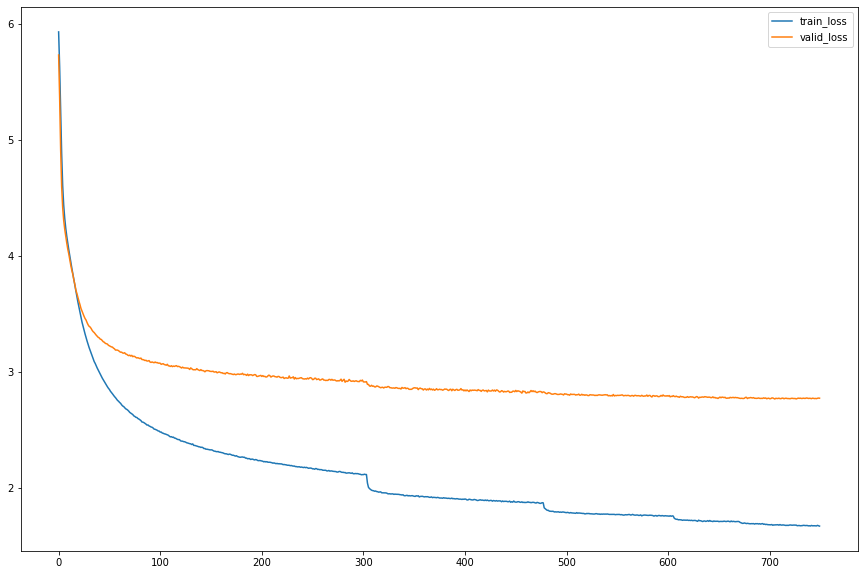

In [38]:
best_val_loss, best_my_transf_model = train_eval_loop(my_transf_model,
                                         train_dataset,
                                         test_dataset,
                                         lm_cross_entropy,
                                         lr=2e-3,
                                         epoch_n=2000,
                                         batch_size=128,
                                         device='cuda',
                                         early_stopping_patience=50,
                                         max_batches_per_epoch_train=1000,
                                         max_batches_per_epoch_val=1000,
                                         lr_scheduler_ctor=lr_scheduler)

In [39]:
torch.save(best_my_transf_model.state_dict(), '../../data/models/war_and_peace_my_transf_best.pth')

In [ ]:
my_transf_model.load_state_dict(torch.load('../../data/models/war_and_peace_my_transf_best.pth'))

## Наша реализация - жадная генерация

In [40]:
my_greedy_generator = GreedyGenerator(my_transf_model, tokenizer)

In [41]:
my_greedy_generator('сказала княжна, оглядывая Андре')

'сказала княжна, оглядывая Андрей, и морщился от болись, как будто от порносил его. - VII. Подложи широкая пехоты, дрожащи'

## Визуализация карт внимания

In [42]:
def plot_attention_maps(model, input_string, tokenizer, device='cuda', max_heads=2, figsize=(16, 10)):
    device = torch.device(device)

    token_ids = tokenizer.encode([input_string])[0]

    token_strs = [tokenizer.id_to_subword(i) for i in token_ids]
    in_len = len(token_ids)
    ticks = np.arange(0, in_len)

    model.to(device)
    model.eval()

    in_batch = torch.tensor(token_ids).unsqueeze(0).to(device)
    model(in_batch)

    for module in model.modules():
        if isinstance(module, MyMultiheadSelfAttention):
            cur_last_attention_map = module.last_attention_map[0].cpu().numpy()
            n_heads = cur_last_attention_map.shape[-1]
            n_heads_to_vis = min(n_heads, max_heads)

            fig, axes = plt.subplots(1, n_heads_to_vis)
            fig.set_size_inches(figsize)
            for head_i in range(n_heads_to_vis):
                ax = axes[head_i]
                ax.imshow(cur_last_attention_map[..., head_i])

                ax.set_yticks(ticks)
                ax.set_ylim(bottom=in_len - 0.5, top=-0.5)
                ax.set_yticklabels(token_strs)

                ax.set_xticks(ticks)
                ax.set_xticklabels(token_strs)

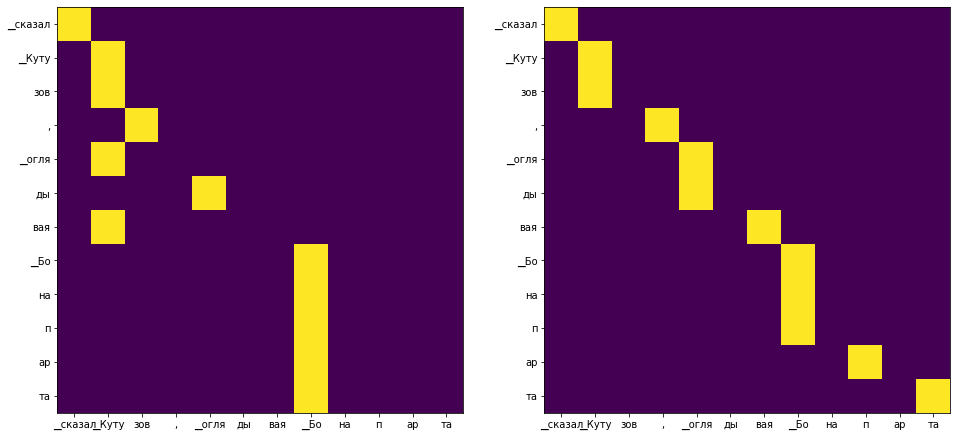

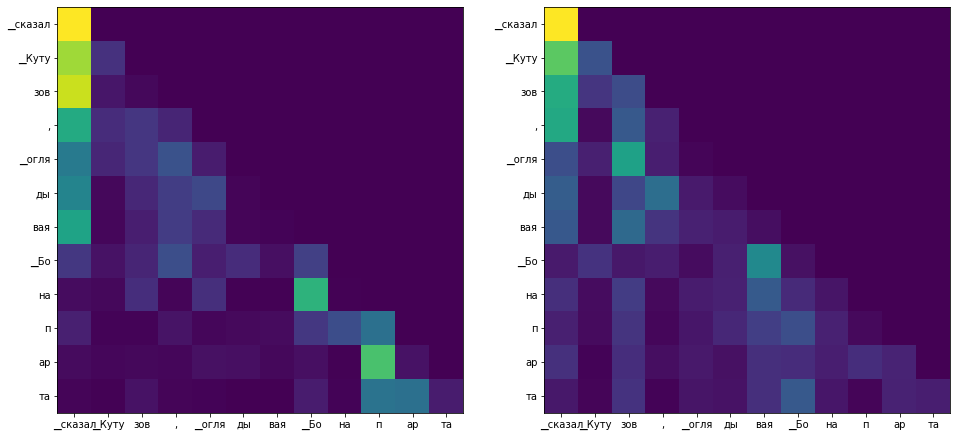

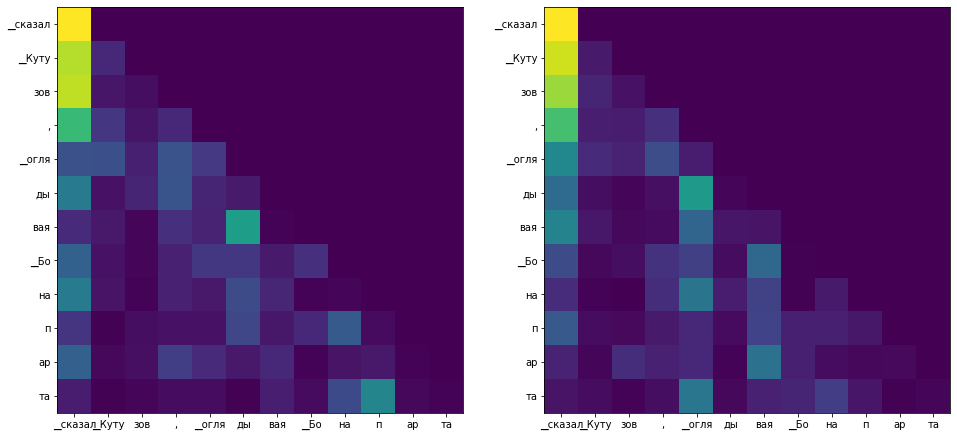

In [43]:
plot_attention_maps(my_transf_model, 'сказал Кутузов, оглядывая Бонапарта', tokenizer)